In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.optim as optims
from torch import nn
import torch.utils.data as Data
import os
import math
import time
from sklearn.linear_model import Lasso,LassoCV, LassoLarsIC
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import jv,yv
torch.set_printoptions(precision=8)
torch.manual_seed(1)
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
torch.set_default_dtype(torch.float64)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# plt.rcParams['font.sans-serif'] = 'Microsoft YaHei' #'Arial'
plt.rcParams['axes.unicode_minus'] = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)

cpu


In [3]:
l_bd = 0.0
r_bd = 1.0

#0阶第一类贝塞尔函数
def Jvs(r):
    return jv(0,r)

#0阶第一类贝塞尔函数的导数
def Jvs_dr(r):
    return -jv(1,r)

# def Jvs(r):
#     return torch.special.bessel_j0(r)

# def Jvs_dr(r):
#     return -torch.special.bessel_j1(r)

def xyToPolar(x,y):
    return torch.sqrt(x**2+y**2)

def xycToPolar(X,c):
    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)
    return torch.sqrt((x.unsqueeze(1)-c[:,0].reshape(-1,1))**2+(y.unsqueeze(1)-c[:,1].reshape(-1,1))**2).squeeze(-1)

#SFSNN的网络输出
def get_u(X,c,h):
    r = xycToPolar(X,c)
    Phi = Jvs(k*r)
    u = torch.matmul(Phi,h).reshape(-1,1)
    return u
    
#SFSNN的网络输出对x的导数
def get_u_dx(X,c,h):
    x = X[:,0].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi = k*Jvs_dr(k*r)*(x.unsqueeze(1)-c[:,0].reshape(-1,1)).squeeze(-1)/r
    u_dx = torch.matmul(Phi,h).reshape(-1,1)
    return u_dx
    
#SFSNN的网络输出对y的导数
def get_u_dy(X,c,h):
    y = X[:,1].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi = k*Jvs_dr(k*r)*(y.unsqueeze(1)-c[:,1].reshape(-1,1)).squeeze(-1)/r
    u_dy = torch.matmul(Phi,h).reshape(-1,1)
    return u_dy

# def Jvs_drr(r,ksi=0):
#     return 0.5*(Jvs(r,ksi+2)-Jvs(r,ksi))

# def get_u_dxx(X,c,h):
#     x = X[:,0].reshape(-1,1)
#     r = xycToPolar(X,c)
#     r[r == 0] += 1e-9
#     Phi = k*Jvs_drr(k*r,0)*((x.unsqueeze(1)-c[:,0].reshape(-1,1)).squeeze(-1)/r)**2+\
#           Jvs_dr(k*r,0)*(r**2-((x.unsqueeze(1)-c[:,0].reshape(-1,1))**2).squeeze(-1))/r**3
#     u_dxx = k*torch.matmul(Phi,h).reshape(-1,1)
#     return u_dxx
    
# def get_u_dyy(X,c,h):
#     y = X[:,1].reshape(-1,1)
#     r = xycToPolar(X,c)
#     r[r == 0] += 1e-9
#     Phi = k*Jvs_drr(k*r,0)*((y.unsqueeze(1)-c[:,1].reshape(-1,1)).squeeze(-1)/r)**2+\
#           Jvs_dr(k*r,0)*(r**2-((y.unsqueeze(1)-c[:,1].reshape(-1,1))**2).squeeze(-1))/r**3
#     u_dxx = k*torch.matmul(Phi,h).reshape(-1,1)
#     return u_dxx

#SFSNN的网络输出对参数c的梯度
def get_u_dc(X,c,h):
    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi_1 = k*h*Jvs_dr(k*r)*(c[:,0].reshape(-1,1)-x.unsqueeze(1)).squeeze(-1)/r
    Phi_2 = k*h*Jvs_dr(k*r)*(c[:,1].reshape(-1,1)-y.unsqueeze(1)).squeeze(-1)/r
    return torch.cat((Phi_1.unsqueeze(-1),Phi_2.unsqueeze(-1)),-1)

#SFSNN的网络输出对权重参数h的梯度
def get_u_dh(X,c):
    r = xycToPolar(X,c)
    Phi = Jvs(k*r)   #m*n
    return Phi

#解析解的6个波源中心
exact_center = torch.tensor([[0.03410820, 0.28674023],
        [0.77291494, 0.17492703],
        [0.75536987, 0.60825063],
        [0.19872715, 0.43341553],
        [0.40484194, 0.77854953],
        [0.18648345, 0.59444020]])

#定义解析解
def u_exact(x):
    r = xycToPolar(x.cpu(),exact_center)
    u = torch.special.bessel_j0(k*r).sum(-1).reshape(-1,1)
    if x.is_cuda:
        u = u.to(device)
    return u

#定义解析解对x的导数，用来计算相对H1误差
def u_dx_exact(X):
    x = X[:,0].reshape(-1,1)
    r = xycToPolar(X,exact_center)
    r[r == 0] += 1e-15
    Phi = k*Jvs_dr(k*r)*(x.unsqueeze(1)-exact_center[:,0].reshape(-1,1)).squeeze(-1)/r
    u_dx = (Phi.sum(-1)).reshape(-1,1)
    return u_dx
    
#定义解析解对y的导数，用来计算相对H1误差
def u_dy_exact(X):
    y = X[:,1].reshape(-1,1)
    r = xycToPolar(X,exact_center)
    r[r == 0] += 1e-15
    Phi = k*Jvs_dr(k*r)*(y.unsqueeze(1)-exact_center[:,1].reshape(-1,1)).squeeze(-1)/r
    u_dy = (Phi.sum(-1)).reshape(-1,1)
    return u_dy

#采样边界点
def SampleBoundPoints(n_bd=2000):
    torch.manual_seed(1)
    x = torch.linspace(l_bd,r_bd,n_bd,dtype=torch.float64).reshape(-1,1)
    y = torch.zeros_like(x,dtype=torch.float64)
    X_1 = torch.cat((x, y), dim=1)  # (x,0)
    X_2 = torch.cat((y + 1, x), dim=1)  # (1,y)
    X_3 = torch.cat((x, y+1), dim=1)  # (x,1)
    X_4 = torch.cat((y, x), dim=1)  # (0,y)
    x_bd = torch.cat((X_1,X_2,X_3,X_4),0)     #边界样本点
    return x_bd

#生成两个边界控制项
def generate_bd_term(x_bd):
    g = u_exact(x_bd)  #迪利克雷边界项
    return g


#计算相对误差
def test_err(net,n=300):
    x0 = torch.linspace(l_bd, r_bd, n)
    mx, my = torch.meshgrid(x0, x0)
    X = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
    u_ex = u_exact(X).flatten()
    u_dx_ex = u_dx_exact(X).flatten()
    u_dy_ex = u_dy_exact(X).flatten()
    u_ex = u_ex.to(device)
    u_dx_ex = u_dx_ex.to(device)
    u_dy_ex = u_dy_ex.to(device)
    net = net.to(device)
    if net.hight.shape[0]>3000:
        use_batch=True
    else:
        use_batch=False
    with torch.no_grad():
        if use_batch:
            dataset = Data.TensorDataset(X)
            data_iter = Data.DataLoader(dataset=dataset, batch_size=2000, shuffle=False)
            u = None
            u_dx = None
            u_dy = None
            for x in data_iter:
                x_part = x[0].to(device)
                u_part = net(x_part).flatten()
                u_dx_part = net.cal_dx(x_part).flatten()
                u_dy_part = net.cal_dy(x_part).flatten()
                if u is None:
                    u = u_part
                    u_dx = u_dx_part
                    u_dy = u_dy_part
                else:
                    u = torch.cat((u,u_part),0)
                    u_dx =  torch.cat((u_dx,u_dx_part),0)
                    u_dy =  torch.cat((u_dy,u_dy_part),0)
                torch.cuda.empty_cache()
        else:
            X = X.to(device)
            u = net(X).flatten()
            u_dx = net.cal_dx(X).flatten()
            u_dy = net.cal_dy(X).flatten()
    Rel_L2 = torch.norm(u_ex-u)/torch.norm(u_ex)  
    Rel_Li = torch.max(torch.abs(u-u_ex))/torch.max(torch.abs(u_ex))
    Rel_H1 = torch.sqrt(torch.norm(u_ex-u)**2+torch.norm(u_dx_ex-u_dx)**2+torch.norm(u_dy_ex-u_dy)**2)/\
                torch.sqrt(torch.norm(u_ex)**2+ torch.norm(u_dx_ex)**2+torch.norm(u_dy_ex)**2)
    print("Rel.L2=",Rel_L2.cpu(),",Rel.Li=",Rel_Li.cpu(),",Rel.H1=",Rel_H1.cpu())
    losswriter.add_scalar('Rel_L2',Rel_L2.cpu().item())
    losswriter.add_scalar('Rel_Li',Rel_Li.cpu().item())
    losswriter.add_scalar('Rel_H1',Rel_H1.cpu().item())
    return Rel_L2,Rel_Li,Rel_H1


#去除无效基函数
def drop_bf(net,tol=0.001):
    net = net.cpu()
    print(f'The number of RBFs before discarding：{net.hight.shape[0]}')
    c, h = net.center.detach(), net.hight.detach()
    index = torch.where(abs(h) > tol)[0]
    c1 = torch.index_select(c, 0, index)
    h1 = torch.index_select(h, 0, index)
    net.center = nn.Parameter(c1)
    net.hight = nn.Parameter(h1)
    print(f'The number of RBFs after discarding：{net.hight.shape[0]}')
    return net

#初始化SFSNN网络的中心分布
def generate_center(N):
    n = int(math.sqrt(N))
    x0 = torch.linspace(0,1,n)
    mx,my = torch.meshgrid((x0,x0))
    center = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
    return center

#定义SFSNN网络
class BesselNet(torch.nn.Module):
    def __init__(self,N=32):
        super(BesselNet, self).__init__()
        torch.manual_seed(1)
        # self.center = nn.Parameter((r_bd-l_bd)*torch.rand(N,2)+l_bd)
        # self.center = nn.Parameter(calculate_circle_coordinates(N,2))
        self.center = nn.Parameter(generate_center(N))
        self.hight = nn.Parameter(torch.rand(N,dtype=torch.float64))

    def forward(self, x):
        u = get_u(x,self.center,self.hight)
        return u

    def cal_dx(self,x):
        return get_u_dx(x,net.center,net.hight)

    def cal_dy(self,x):
        return get_u_dy(x,net.center,net.hight)

    def cal_dxx(self,x):
        return get_u_dxx(x,net.center,net.hight)

    def cal_dyy(self,x):
        return get_u_dyy(x,net.center,net.hight)

#计算LASSO问题的系数矩阵和右端向量
def cal_Jacobi(net,x_bd):
    t1 = time.time()
    with torch.no_grad():
        A = get_u_dh(x_bd,net.center.data)
        f = generate_bd_term(x_bd)
    t2 = time.time()
    print('计算系数矩阵耗时=',t2-t1)
    print('A.shape',A.shape,f.shape)
    return A.detach(),f.detach()

#求解线性最小二乘问题：Ax=f
def solve_coeff(net,A,f):  #solve  Ax=f
    test_err(net)
    net = net.cpu()
    # print("A的条件数=",torch.linalg.cond(A))
    index1 = torch.where(abs(net.hight) > 1e-5)[0]
    print("初始有效基函数个数=",index1.shape[0])
    err_ini = torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f)
    print("初始误差,err_norm=",torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f))
    t1 = time.time()
    bestP = torch.linalg.lstsq(A,f,driver='gelsd')[0] #‘gels’ , ‘gelsy’ , ‘gelsd , ‘gelss’
    t2 = time.time()
    print("最小二乘求解耗时=",t2-t1)
    net.hight = nn.Parameter(bestP.flatten())
    print("最小二乘求解后,err_norm=",torch.norm(torch.matmul(A,bestP).reshape(-1,1)-f))
    print("最小二乘求解后,相对误差:")
    test_err(net)
    net = net.to(device)
    return net

#记录损失
class LossWriter:
    def __init__(self, filename):
        self.filename = filename
        self.data = {}

    def add_scalar(self, tag, scalar_value):
        if tag not in self.data:
            self.data[tag] = []
        self.data[tag].append(scalar_value)
        
    def save(self):
        # 保存数据为npz格式
        np.savez(self.filename, **self.data)


#求解LASSO问题：||Ax-f||+\lam||x||_1
def solve_coeff_lasso(net,A,f,lam=0.001,cri=None):  #solve  Ax=f
    # test_err(net)
    net = net.cpu()
    # print("A的条件数=",torch.linalg.cond(A))
    index1 = torch.where(abs(net.hight) > 1e-5)[0]
    print("初始有效基函数个数=",index1.shape[0])
    err_ini = torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f)
    print("初始误差,err_norm=",torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f))
    t1 = time.time()
    if cri=='aic':
        clf = LassoLarsIC('aic',fit_intercept=False)
        clf.fit(A,f)  
        print('使用aic,最佳的lam=',clf.alpha_)
    elif cri=='bic':
        clf = LassoLarsIC('bic',fit_intercept=False)
        clf.fit(A,f)  
        print('使用bic,最佳的lam=',clf.alpha_)
    else:
        clf = Lasso(lam,fit_intercept=False)
        clf.fit(A,f) 
        print('使用指定的lam=',lam)
    h = torch.tensor(clf.coef_)
    t2 = time.time()
    print('lasso 求解耗时=',t2-t1)
    net.hight = nn.Parameter(h.flatten())
    print("lasso求解后,err_norm=",torch.norm(torch.matmul(A,h).reshape(-1,1)-f))
    print("lasso求解后,相对误差:")
    test_err(net)
    net = net.to(device)
    return net

前6个基函数系数= tensor([1.00000293, 1.00000085, 0.99999578, 0.99999419, 0.99999403, 0.99999374]) ,所有系数= tensor([1.00000293, 1.00000085, 0.99999578, 0.99999403, 0.99999419, 0.99999374])
总基函数个数: 6 绘制前6个基函数


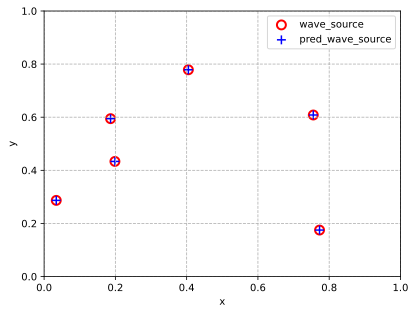

AssertionError: 

In [ ]:
def caldc(c1,c2):
    dc = (abs(c1-c2)).sum(-1)
    print("center变动最大的:",torch.max(dc).cpu().item())

def caldh(h1,h2):
    print("hight中变动最大的:",torch.max(abs(h1-h2)).cpu().item())

#合并基函数，将两个中心距离较小的基函数合并为一个
def merge_bf(center,hight,tol=0.01):
    distances = torch.cdist(center,center)
    # print(distances)
    c_new,h_new = [],[]
    index = torch.arange(distances.shape[0])
    i = 0
    while (len(index)>0)&(i<hight.shape[0]):
        dis = distances[i,:]
        index_i = torch.where(dis<tol)[0]
        c = 0
        h = 0
        # print('i=',i,'dis=',dis)
        num= len(index)
        for j in index_i:
            if j not in index:
                continue
            c += center[j,:]
            h += hight[j]
            if len(index)==1:
                index= []
            else:
                index_del = np.where(index==j)
                index = np.delete(index,index_del) 
            # print('j=',j,'index=',index)
        # print(min(len(index_i),num))
        # print('c1=',c/min(len(index_i),num),'h1=',h)
        c_new.append(c/min(len(index_i),num))
        h_new.append(h)
        # print('index=',index,len(index))
        if len(index)>0:
            i = index[0]
        else:
            i = i+1
    # print(len(c_new),c_new)
    # print(len(h_new),h_new)
    # c_new = torch.tensor(np.array(c_new))
    # h_new = torch.tensor(np.array(h_new))
    c_new = torch.tensor(np.array([t.numpy() for t in c_new]))
    h_new = torch.tensor(np.array([t.numpy() for t in h_new]))
    print('合并前的中心=',center,'合并前的系数=',hight)
    print('合并后的中心=',c_new,'合并后的系数=',h_new)
    return c_new,h_new
    
#训练SFSNN网络
def train(net,x_bd,losswriter,lr,MaxNiter,lam,tol,tol_c):
    t_all = 0.0
    test_err(net)
    g = generate_bd_term(x_bd)   #边界控制项
    g = g.to(device)
    net = net.to(device)
    optimizer = optims.Adam([{"params":net.center,"lr":lr},{"params":net.hight,"lr":lr}])
    x_bd = x_bd.to(device)
    for Niter in range(1, MaxNiter):
        l_bd_sum = 0.0
        t1 = time.time()
        optimizer.zero_grad()
        with torch.no_grad():
            u_bd = get_u(x_bd,net.center,net.hight)  
            u_bd_dc = get_u_dc(x_bd,net.center,net.hight)
            u_bd_dh = get_u_dh(x_bd,net.center)
        c1 = net.center.clone()
        h1 = net.hight.clone()
        l_bd = ((u_bd-g)**2).sum() 
        net.center.grad = (2*(u_bd-g).unsqueeze(-1)*u_bd_dc).sum(0)
        net.hight.grad = (2*(u_bd-g)*u_bd_dh).sum(0)
        optimizer.step()
        c2 = net.center.data
        h2 = net.hight.data
       
        t2 = time.time()
        t_all += t2-t1
        if (Niter%200==0)&(optimizer.param_groups[0]['lr']>=0.001):
            for i in range(len(optimizer.param_groups)):
                optimizer.param_groups[i]['lr']=0.1*optimizer.param_groups[i]['lr']
        print('k=%d,t_all=%.3f,t_Niter=%.3f,Niter:%d,l_bd:%.8f,lr:%.8f' 
            % (k,t_all,t2-t1, Niter, l_bd.cpu().item(),optimizer.param_groups[0]['lr']))
        if Niter%10==0:
            torch.save(net.state_dict(), 'model/2d_exam2_%d.pth'%int(k))
            test_err(net)
            losswriter.save()
            # caldc(c1,c2)
            # caldh(h1,h2)
            # print('center=',net.center.data,'hight=',net.hight.data)
            # plot_center(net)
            losswriter.add_scalar('N_bf',net.hight.data.cpu().shape[0])
            
        if (Niter%1000==0)&(net.hight.shape[0]>1)&(Niter<MaxNiter-500):#
            net = net.cpu()
            net = drop_bf(net,tol)
            center_new,hight_new = merge_bf(net.center.data,net.hight.data,tol_c)
            net.center = nn.Parameter(center_new)
            net.hight = nn.Parameter(hight_new)
            A,f = cal_Jacobi(net,x_bd.cpu())
            net = solve_coeff_lasso(net,A,f,lam)
            net = drop_bf(net,tol)
            # plot_center(net)
            # print('center=',net.center.data,'hight=',net.hight.data)
            net = net.to(device)
            optimizer = optims.Adam([{"params":net.center,"lr":lr},\
                                     {"params":net.hight,"lr":lr}])
    net = net.cpu()
    x_bd = x_bd.cpu()
    A,f = cal_Jacobi(net,x_bd)
    net = solve_coeff(net,A,f)
    torch.save(net.state_dict(), 'model/2d_exam2_%d.pth'%int(k))
    test_err(net)
    losswriter.save()
    plot_center(net,save_path='imgs/2d_exam2/k_%d_final_center.png'%k)
    return net

#绘制基函数的中心分布
# def plot_center(net,num=6,save_path=None):
#     # index = torch.where(abs(net.hight.data.cpu()) > 1e-5)[0]
#     top_values, index = torch.topk(abs(net.hight.data.cpu()), k=num, largest=True)
#     print('前8个基函数系数=',top_values,',所有系数=',net.hight.data.cpu())
#     print('总基函数个数:',net.hight.shape[0],'绘制前%d个基函数'%num)
#     plt.grid(linestyle="--")
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.scatter(exact_center[:,0],exact_center[:,1],c='r',marker='o',label='wave_source')
#     blue_label_added = False
#     yellow_label_added = False
#     for i in range(len(net.hight.data.cpu())):
#         if not yellow_label_added:
#             plt.scatter(net.center.data.cpu()[i,0],net.center.data.cpu()[i,1],c='b',marker='+',label='pred_wave_source')
#             yellow_label_added = True
#         else:
#             plt.scatter(net.center.data.cpu()[i,0],net.center.data.cpu()[i,1],c='b',marker='+')
    
#     plt.legend(loc='upper right')
#     plt.xlim([0,1])
#     plt.ylim([0,1])
#     if save_path is not None:
#         plt.savefig(save_path)
#     plt.show()

def plot_center(net,num=6,save_path=None):
    # index = torch.where(abs(net.hight.data.cpu()) > 1e-5)[0]
    top_values, index = torch.topk(abs(net.hight.data.cpu()), k=num, largest=True)
    print('前%d个基函数系数='%num,top_values,',所有系数=',net.hight.data.cpu())
    print('总基函数个数:',net.hight.shape[0],'绘制前%d个基函数'%num)
    plt.grid(linestyle="--")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([0,1])
    plt.ylim([0,1])

    sz = 80
    # 创建散点图  
    plt.scatter(exact_center[:, 0], exact_center[:, 1],   
                c='none',              # 颜色设置为红色  
                marker='o',        # 圆形标记  
                linewidths=2.0,
                s=sz,             # 调整标记大小，单位是平方点  
                edgecolor='r',     # 圆的边缘颜色  
                facecolor='none',  # 圆的填充颜色设为无，即空心  
                label='wave_source')  

    #plt.scatter(exact_center[:,0],exact_center[:,1],c='r',marker='o',label='wave_source')
    blue_label_added = False
    yellow_label_added = False
    for i in range(len(net.hight.data.cpu())):
        
        if not yellow_label_added:
            plt.scatter(net.center.data.cpu()[i,0],net.center.data.cpu()[i,1],s=sz,c='b',marker='+',label='pred_wave_source')
            yellow_label_added = True
        else:
            plt.scatter(net.center.data.cpu()[i,0],net.center.data.cpu()[i,1],s=sz,c='b',marker='+')
    
    plt.legend(loc='upper right')
    plt.xlim([0,1])
    plt.ylim([0,1])
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

#加载已训练模型
def load_model(net):
    model = torch.load('model/2d_exam2/2d_exam2_%d.pth'%int(k),map_location='cpu')#
    net.center = nn.Parameter(model['center'])
    net.hight = nn.Parameter(model['hight'])
    return net

k = 200
lr = 0.01
MaxNiter = 5000
n_bd = 2*k
N = int(k/2)**2
tol = 0.001
tol_c = 0.01
torch.manual_seed(1)
lam = 0.002#0.1,0.01,,0.0001,0.00001,0.000001

x_bd = SampleBoundPoints(n_bd)
net = BesselNet(N)
net = load_model(net)
# plot_center(net,save_path='imgs/2d_exam2/k_%d_final_center.png'%k)

test_err(net)
assert 1==2

losswriter = LossWriter('loss/loss_exam2_%d_%d.npz'%(k,N))
losswriter.add_scalar('k',k)
losswriter.add_scalar('MaxNiter',MaxNiter)
losswriter.add_scalar('n_bd',n_bd)
losswriter.add_scalar('lr',lr)
losswriter.add_scalar('N',N)
losswriter.add_scalar('lam',lam)
losswriter.add_scalar('N_bf',net.hight.data.cpu().shape[0])
losswriter.add_scalar('tol',tol)
losswriter.add_scalar('tol_c',tol_c)

A,f = cal_Jacobi(net,x_bd)
net = solve_coeff_lasso(net,A,f,lam)#
net = drop_bf(net,tol)
# net = load_model(net)
torch.save(net.state_dict(), 'model/2d_exam2/2d_exam2_%d_init.pth'%int(k))
# L2,_,_= test_err(net)
# print('lam=',lam,',L2=',L2)
plot_center(net,save_path='imgs/2d_exam2/k_%d_init_center.png'%k)
train(net,x_bd,losswriter,lr,MaxNiter,lam,tol,tol_c)


In [ ]:
def load_model(net):
    model = torch.load('model/2d_exam2_init_%d.pth'%int(k))
    net.center = nn.Parameter(model['center'])
    net.hight = nn.Parameter(model['hight'])
    return net

k = 200
lr = 0.01
MaxNiter = 5000
n_bd = 2*k
N = int(k/2)**2
tol = 0.001
tol_c = 0.01
torch.manual_seed(1)
lam = 0.002#0.1,0.01,,0.0001,0.00001,0.000001

x_bd = SampleBoundPoints(n_bd)
net = BesselNet(N)
net = load_model(net)
plot_center(net,save_path='imgs/2d_exam2/k_%d_final_center.png'%k)